# Курсовая работа. Предсказание стоимости дома на основе данных о ряде домов в Калифорнии.

## Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from scipy import stats
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

## Пути к директориям и файлам

In [3]:
DATASET_PATH = './housing.csv'
PREPARED_DATASET_PATH = './housing_prepared.csv'
CALIFORNIA_MAP_PATH = './California_Map.png'

## Загрузка данных

In [4]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3


## Анализ данных

### Проведем статистический анализ данных

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,20640.000000,20640.000000,19918.000000,20640.000000,20433.000000,20041.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.471242,35.036934,28.653630,2635.763081,537.870553,1425.418243,499.539680,3.870671,206855.816909,10319.500000
std,5.041408,94.903955,12.576796,2181.615252,421.385070,1135.185798,382.329753,1.899822,115395.615874,5958.399114
min,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,786.000000,280.000000,2.563400,119600.000000,5159.750000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1165.000000,409.000000,3.534800,179700.000000,10319.500000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1726.000000,605.000000,4.743250,264725.000000,15479.250000
max,122.030000,1327.130000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,20639.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  19918 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20041 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  id                  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


### Обзор номинативных переменных

In [7]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [8]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9127
INLAND        6542
NEAR OCEAN    2655
NEAR BAY      2288
-               23
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', '-', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

### Обработка пропусков значений в признаках

In [10]:
df.isna()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
20635,False,False,False,False,False,False,False,False,False,False,False
20636,False,False,False,False,False,False,False,False,False,False,False
20637,False,False,False,False,False,True,False,False,False,False,False
20638,False,False,False,False,False,False,False,False,False,False,False


In [11]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age    722
total_rooms             0
total_bedrooms        207
population            599
households              0
median_income           0
median_house_value      0
ocean_proximity         0
id                      0
dtype: int64

Что можно делать с ними?
1. Выкинуть эти данные
2. Заменять пропуски разными методами (медианы, средние значения и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

Попробуем удалить записи, где есть пустые значения в признаках. Как мне кажется, в таком случае мы избавимся от недостоверных данных, которые могут помешать корректному обучению модели.

In [12]:
df.dropna(subset=["housing_median_age"], inplace=True)

In [13]:
df.dropna(subset=["total_bedrooms"], inplace=True)

In [14]:
df.dropna(subset=["population"], inplace=True)

### Поработаем с признаком **OCEAN_PROXIMITY**

In [15]:
df['ocean_proximity_nan'] = 0
df.loc[df['ocean_proximity'] == '-', 'ocean_proximity_nan'] = 1

In [16]:
df[df['ocean_proximity_nan'] == 1].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan
1153,-121.46,39.54,14.0,5549.0,1000.0,1822.0,919.0,2.9562,142300.0,-,1153,1
2435,-119.59,36.57,19.0,1733.0,303.0,911.0,281.0,3.5987,131700.0,-,2435,1
2636,-124.15,40.59,39.0,1186.0,238.0,539.0,212.0,2.0938,79600.0,-,2636,1
5980,-117.74,34.10,26.0,2723.0,604.0,1847.0,498.0,2.6779,136000.0,-,5980,1
6373,-118.02,34.15,44.0,2419.0,437.0,1045.0,432.0,3.8750,280800.0,-,6373,1


Заменим значение "-" в признаке ocean_proximity на самое популярное значение в признаке, то есть на моду.

In [17]:
df.replace(
    {'ocean_proximity':
     {'-': df['ocean_proximity'].mode()[0]}
    },
    inplace=True)

In [18]:
df['ocean_proximity'].value_counts()

<1H OCEAN     8481
INLAND        6075
NEAR OCEAN    2457
NEAR BAY      2134
ISLAND           5
Name: ocean_proximity, dtype: int64

## Обработка выбросов

Что можно делать с ними?
1. Выкинуть эти данные
2. Заменять выбросы разными методами (медианы, средние значения и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**longitude**

In [19]:
df[df['longitude'] >= 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan
3479,118.51,34.29,29.0,1287.0,194.0,525.0,187.0,6.4171,319300.0,<1H OCEAN,3479,0
5904,118.43,34.29,39.0,1769.0,410.0,1499.0,390.0,3.1212,153500.0,<1H OCEAN,5904,0
8405,118.36,33.93,40.0,1625.0,500.0,2036.0,476.0,2.6298,156500.0,<1H OCEAN,8405,0
8636,118.41,33.88,43.0,2492.0,449.0,1033.0,437.0,7.9614,500001.0,<1H OCEAN,8636,0
13051,121.29,38.61,17.0,13553.0,2474.0,6544.0,2359.0,3.9727,132700.0,INLAND,13051,0
15263,117.27,33.02,21.0,2144.0,340.0,928.0,344.0,5.7980,286100.0,NEAR OCEAN,15263,0
17085,0.00,37.47,33.0,1266.0,415.0,1991.0,334.0,2.9200,202800.0,NEAR OCEAN,17085,0
17359,0.00,34.88,4.0,3680.0,559.0,1678.0,569.0,5.0639,201700.0,<1H OCEAN,17359,0
18551,122.03,36.96,28.0,1607.0,421.0,926.0,385.0,2.4250,216100.0,NEAR OCEAN,18551,0
19423,0.00,37.69,5.0,9601.0,1639.0,4449.0,1575.0,4.5332,195500.0,INLAND,19423,0


In [20]:
df[df['longitude'] < 0].count()

longitude              19142
latitude               19142
housing_median_age     19142
total_rooms            19142
total_bedrooms         19142
population             19142
households             19142
median_income          19142
median_house_value     19142
ocean_proximity        19142
id                     19142
ocean_proximity_nan    19142
dtype: int64

In [21]:
df[df['longitude'] >= 0].count()

longitude              10
latitude               10
housing_median_age     10
total_rooms            10
total_bedrooms         10
population             10
households             10
median_income          10
median_house_value     10
ocean_proximity        10
id                     10
ocean_proximity_nan    10
dtype: int64

Как мы видим, есть 10 странных аномальных значений долготы (отрицательных), которые не похожи на все остальные. Учитывая, что недвижимость мы оцениваем в одном регионе, то долгота не может настолько отличаться от основной массы значений.
\
Поменяем этим значениям знак, а нули заменим на медиану

In [22]:
df['longitude_outlier'] = 0
df.loc[df['longitude'] >= 0, 'longitude_outlier'] = 1

In [23]:
df[df['longitude'] >= 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,longitude_outlier
3479,118.51,34.29,29.0,1287.0,194.0,525.0,187.0,6.4171,319300.0,<1H OCEAN,3479,0,1
5904,118.43,34.29,39.0,1769.0,410.0,1499.0,390.0,3.1212,153500.0,<1H OCEAN,5904,0,1
8405,118.36,33.93,40.0,1625.0,500.0,2036.0,476.0,2.6298,156500.0,<1H OCEAN,8405,0,1
8636,118.41,33.88,43.0,2492.0,449.0,1033.0,437.0,7.9614,500001.0,<1H OCEAN,8636,0,1
13051,121.29,38.61,17.0,13553.0,2474.0,6544.0,2359.0,3.9727,132700.0,INLAND,13051,0,1
15263,117.27,33.02,21.0,2144.0,340.0,928.0,344.0,5.7980,286100.0,NEAR OCEAN,15263,0,1
17085,0.00,37.47,33.0,1266.0,415.0,1991.0,334.0,2.9200,202800.0,NEAR OCEAN,17085,0,1
17359,0.00,34.88,4.0,3680.0,559.0,1678.0,569.0,5.0639,201700.0,<1H OCEAN,17359,0,1
18551,122.03,36.96,28.0,1607.0,421.0,926.0,385.0,2.4250,216100.0,NEAR OCEAN,18551,0,1
19423,0.00,37.69,5.0,9601.0,1639.0,4449.0,1575.0,4.5332,195500.0,INLAND,19423,0,1


In [24]:
df.loc[df['longitude'] > 0, 'longitude'] * -1

3479    -118.51
5904    -118.43
8405    -118.36
8636    -118.41
13051   -121.29
15263   -117.27
18551   -122.03
Name: longitude, dtype: float64

In [25]:
df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1

In [26]:
df.loc[df['longitude'] == 0, 'longitude'] = df['longitude'].median()

Проверим, что получилось после замен.

In [27]:
df[df['longitude'] >= 0].count()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
id                     0
ocean_proximity_nan    0
longitude_outlier      0
dtype: int64

**latitude**

In [28]:
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,longitude_outlier
8283,-118.13,-13534.03,45.0,1016.0,172.0,361.0,163.0,7.5,434500.0,NEAR OCEAN,8283,0,0


In [29]:
df['latitude_outlier'] = 0
df.loc[(df['latitude'] <= 0) | (df['latitude'] > 50), 'latitude_outlier'] = 1

In [30]:
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,longitude_outlier,latitude_outlier
8283,-118.13,-13534.03,45.0,1016.0,172.0,361.0,163.0,7.5,434500.0,NEAR OCEAN,8283,0,0,1


Заменим аномальные данные по широте на медианное значение

In [31]:
df.loc[(df['latitude'] <= 0) | (df['latitude'] > 50), 'latitude'] = df['latitude'].median()

In [32]:
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,longitude_outlier,latitude_outlier


**total_rooms**

Найдем выбросы с помощью квантилей. Наблюдения, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля будем считать выбросами и заменять на медиану.

In [33]:
df['total_rooms'].describe()

count    19152.000000
mean      2632.123956
std       2170.428422
min          2.000000
25%       1449.750000
50%       2124.000000
75%       3138.250000
max      37937.000000
Name: total_rooms, dtype: float64

In [34]:
total_rooms_max_value = np.quantile(df['total_rooms'], q=0.975)
total_rooms_max_value

8024.274999999972

In [35]:
total_rooms_min_value = np.quantile(df['total_rooms'], q=0.025)
total_rooms_min_value

369.77500000000003

In [36]:
condition = (df['total_rooms'] > total_rooms_max_value) | (df['total_rooms'] < total_rooms_min_value)
df[condition]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,longitude_outlier,latitude_outlier
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,59,0,0,0
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,61,0,0,0
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY,73,0,0,0
81,-122.27,37.81,52.0,210.0,56.0,183.0,56.0,1.1667,112500.0,NEAR BAY,81,0,0,0
82,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,112500.0,NEAR BAY,82,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20578,-121.81,38.84,37.0,352.0,65.0,238.0,67.0,2.8542,275000.0,INLAND,20578,0,0,0
20620,-121.48,39.05,40.0,198.0,41.0,151.0,48.0,4.5625,100000.0,INLAND,20620,0,0,0
20625,-121.52,39.12,37.0,102.0,17.0,29.0,14.0,4.1250,72000.0,INLAND,20625,0,0,0
20627,-121.32,39.13,5.0,358.0,65.0,169.0,59.0,3.0000,162500.0,INLAND,20627,0,0,0


Заменим выбросы на медианное значение

In [37]:
df.loc[condition, 'total_rooms'] = df['total_rooms'].median()
df['total_rooms'].describe()

count    19152.000000
mean      2433.447421
std       1356.565787
min        370.000000
25%       1512.000000
50%       2124.000000
75%       3000.500000
max       8020.000000
Name: total_rooms, dtype: float64

## Отбор и построение новых признаков

Исключаем признак "id"

In [38]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'id', 'ocean_proximity_nan',
       'longitude_outlier', 'latitude_outlier'],
      dtype='object')

In [39]:
df.drop(columns='id', inplace=True)

In [40]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'ocean_proximity_nan',
       'longitude_outlier', 'latitude_outlier'],
      dtype='object')

**Количественные переменные**

In [41]:
# Доля спален в общем кол-ве комнат
df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100

# Сколько человек в среднем живут в одной комнате
df['population_per_room'] = df['population'] / df['total_rooms']

In [42]:
df[['bedroom_share', 'population_per_room']].head()

,bedroom_share,population_per_room
0,14.659091,0.365909
1,15.579659,0.338217
2,12.951602,0.338105
3,18.445840,0.437991
4,17.209588,0.347265


**Категориальные переменные**

Неколичественные строковые признаки всегда нужно переводить в числовое представление, так как многие модели машинного обучения не способны работать со строками.

In [43]:
df['ocean_proximity'].value_counts()

<1H OCEAN     8481
INLAND        6075
NEAR OCEAN    2457
NEAR BAY      2134
ISLAND           5
Name: ocean_proximity, dtype: int64

Создадим дамми переменные для признака **OCEAN_PROXIMITY**

In [44]:
df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_nan,longitude_outlier,latitude_outlier,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,0,0,14.659091,0.365909,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0,0,0,15.579659,0.338217,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0,0,0,12.951602,0.338105,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0,0,0,18.445840,0.437991,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0,0,0,17.209588,0.347265,0,0,0,1,0


In [45]:
df['<1H OCEAN'] = df['<1H OCEAN'].astype(np.int8)
df['INLAND'] = df['<1H OCEAN'].astype(np.int8)
df['ISLAND'] = df['<1H OCEAN'].astype(np.int8)
df['NEAR BAY'] = df['<1H OCEAN'].astype(np.int8)
df['NEAR OCEAN'] = df['<1H OCEAN'].astype(np.int8)

**Вещественные переменные**

In [46]:
df['housing_median_age'].describe()

count    19152.000000
mean        28.612573
std         12.591204
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

**Feature binarization**

только 1 признак

1 - новый дом,\
0 - старый

In [47]:
def age_to_binary_cat(X):

    X['age_binary_cat'] = 0
    X.loc[X['housing_median_age'] <= 5, 'age_binary_cat'] = 1  

    return X

In [48]:
df = age_to_binary_cat(df)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,longitude_outlier,latitude_outlier,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,age_binary_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,0,0,14.659091,0.365909,0,0,0,0,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,0,0,15.579659,0.338217,0,0,0,0,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,...,0,0,12.951602,0.338105,0,0,0,0,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,...,0,0,18.445840,0.437991,0,0,0,0,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,...,0,0,17.209588,0.347265,0,0,0,0,0,0


### Сохранение результатов

In [49]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

# Визуализация и анализ данных

## Уменьшение объема памяти, который занимает датасет

In [50]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [51]:
df.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity         object
ocean_proximity_nan      int64
longitude_outlier        int64
latitude_outlier         int64
bedroom_share          float64
population_per_room    float64
<1H OCEAN                 int8
INLAND                    int8
ISLAND                    int8
NEAR BAY                  int8
NEAR OCEAN                int8
age_binary_cat           int64
dtype: object

In [52]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.58 MB
Memory usage after optimization is: 1.13 MB
Decreased by 56.0%


In [53]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
ocean_proximity_nan        int8
longitude_outlier          int8
latitude_outlier           int8
bedroom_share           float32
population_per_room     float32
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
age_binary_cat             int8
dtype: object

## Распределение целевой переменной

[0, 0, 3, 5, 7, 8, 8, 8, 8, 9]
median - 7.5
mean - 5.6
mode - 8


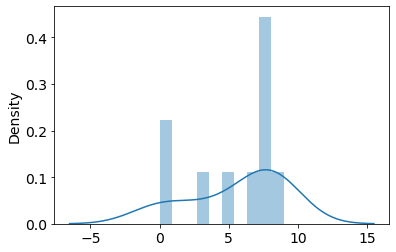

In [54]:
x = np.random.randint(0, 10, 10)
print(sorted(x))
print(f'median - {np.quantile(x, q=0.5)}\nmean - {np.mean(x)}\nmode - {stats.mode(x)[0][0]}')
sns.distplot(x, bins=10);

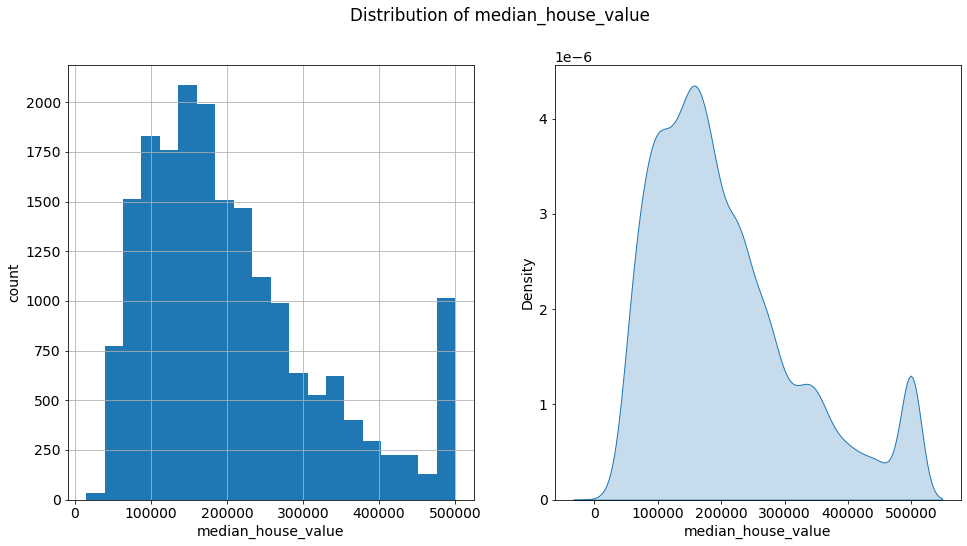

In [55]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['median_house_value'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.subplot(122)
sns.kdeplot(df['median_house_value'], shade=True, legend=False)
plt.xlabel('median_house_value')

plt.suptitle('Distribution of median_house_value')
plt.show()

In [56]:
target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]

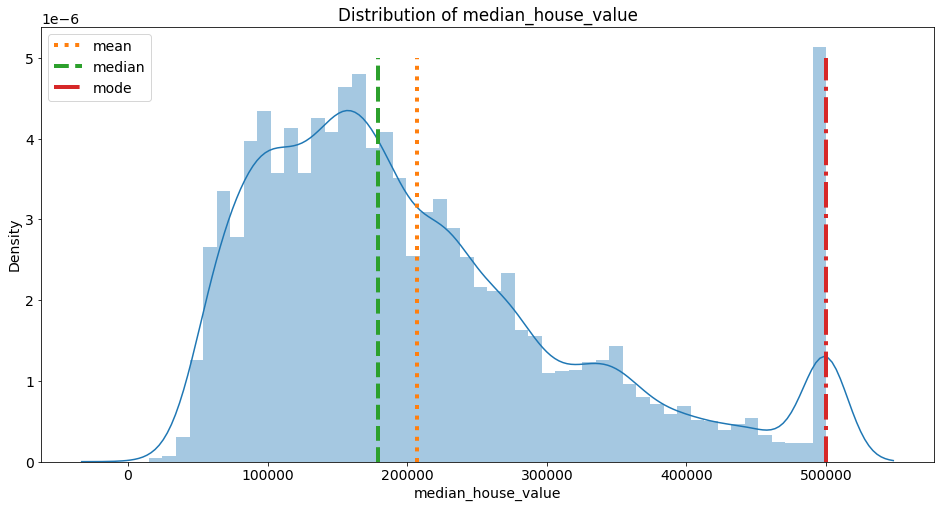

In [57]:
plt.figure(figsize = (16, 8))

sns.distplot(df['median_house_value'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

Уберем странные значения из выборки

In [58]:
df['median_house_value'].value_counts()

500001.0    892
137500.0    115
162500.0    113
112500.0     96
187500.0     83
           ... 
76000.0       1
36600.0       1
33200.0       1
48900.0       1
47000.0       1
Name: median_house_value, Length: 3776, dtype: int64

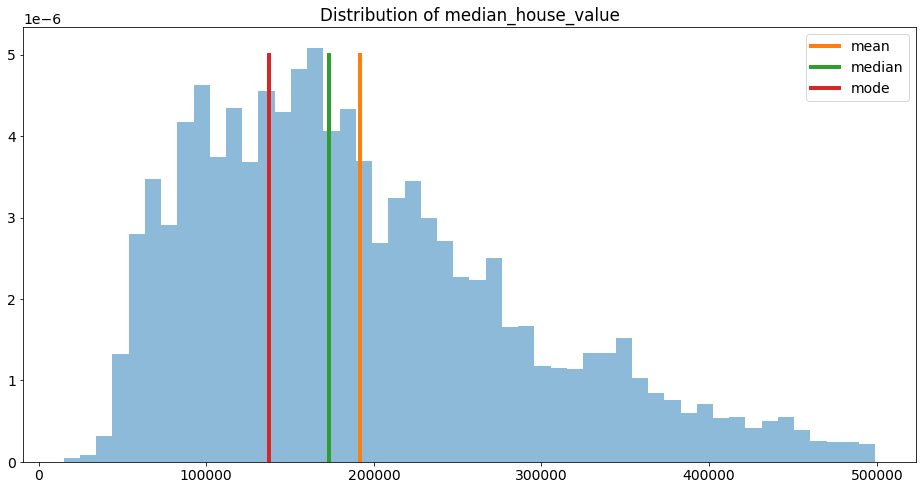

In [59]:
df = df[df['median_house_value'] < 500000]

target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]

plt.figure(figsize = (16, 8))
plt.hist(df['median_house_value'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

## Анализ признаков

In [60]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('median_house_value', axis=1, inplace=True)

In [61]:
df_num_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedroom_share,population_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,14.659091,0.365909
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,15.579659,0.338217
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,12.951602,0.338105
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,18.445839,0.437991
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,17.209589,0.347265
...,...,...,...,...,...,...,...,...,...,...
20634,-121.559998,39.270000,28.0,2332.0,395.0,1041.0,344.0,3.7125,16.938250,0.446398
20635,-121.089996,39.480000,25.0,1665.0,374.0,845.0,330.0,1.5603,22.462463,0.507508
20636,-121.209999,39.490002,18.0,697.0,150.0,356.0,114.0,2.5568,21.520803,0.510760
20638,-121.320000,39.430000,18.0,1860.0,409.0,741.0,349.0,1.8672,21.989246,0.398387


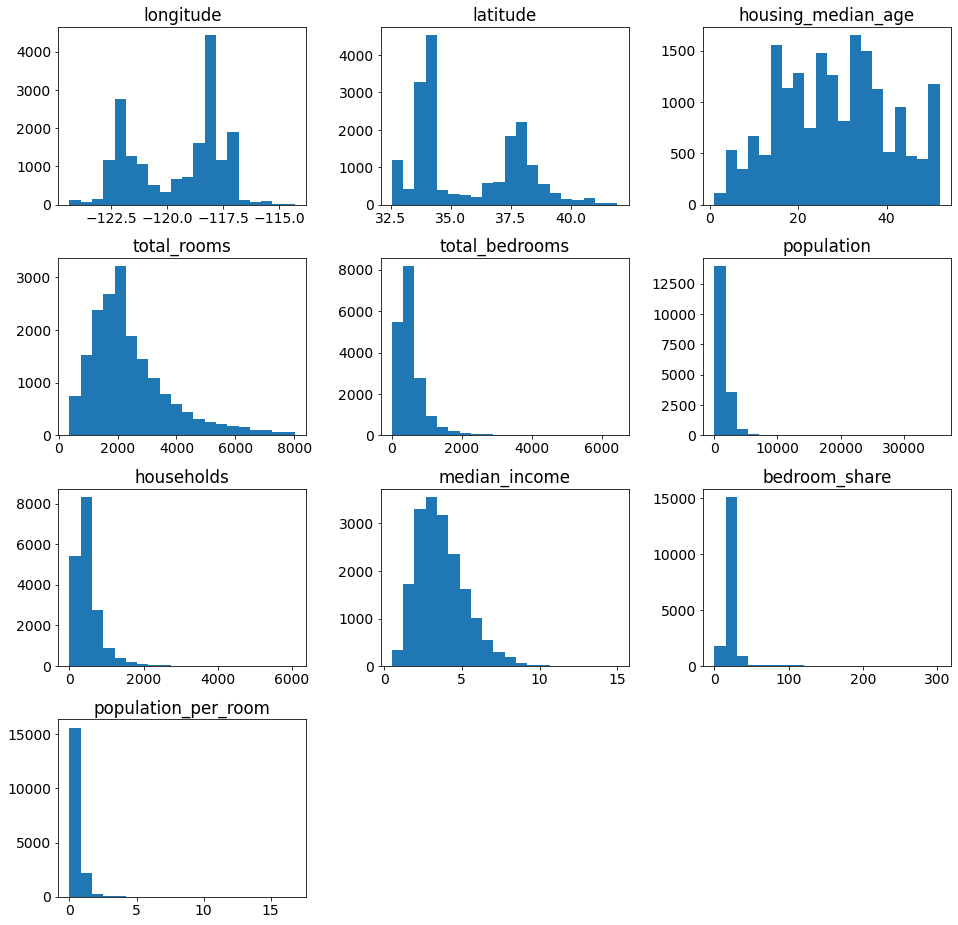

In [62]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

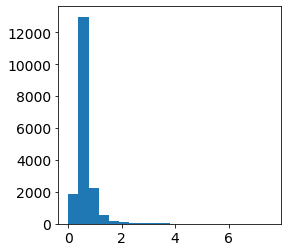

In [63]:
df.loc[df['population_per_room'] < 10, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [64]:
df.loc[df['population_per_room'] > 2.5, 'population_per_room'] = df['population_per_room'].median()

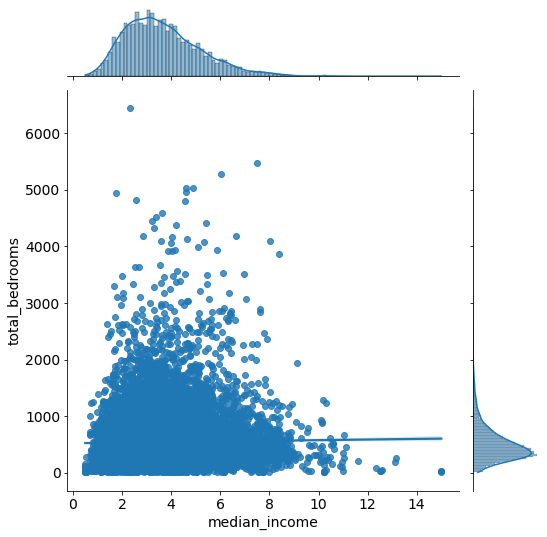

In [65]:
grid = sns.jointplot(df['median_income'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

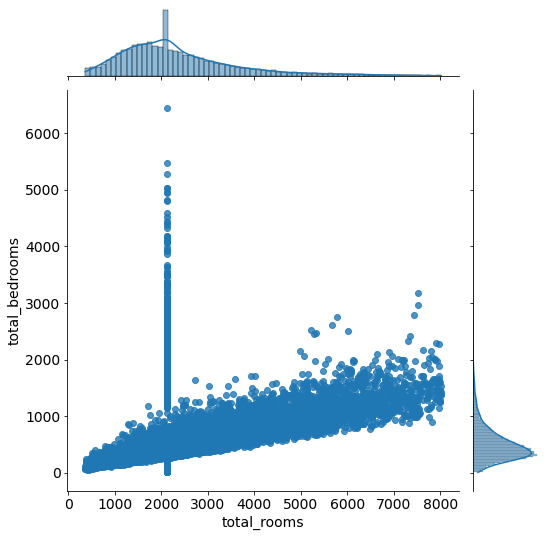

In [66]:
grid = sns.jointplot(df['total_rooms'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [67]:
df['total_bedrooms'].median()

435.0

In [68]:
df[df['total_bedrooms'] == 435].shape[0] * 100 / df.shape[0]

0.1809805857189865

In [69]:
df[df['total_bedrooms'] == df['total_bedrooms'].median()].shape[0]

33

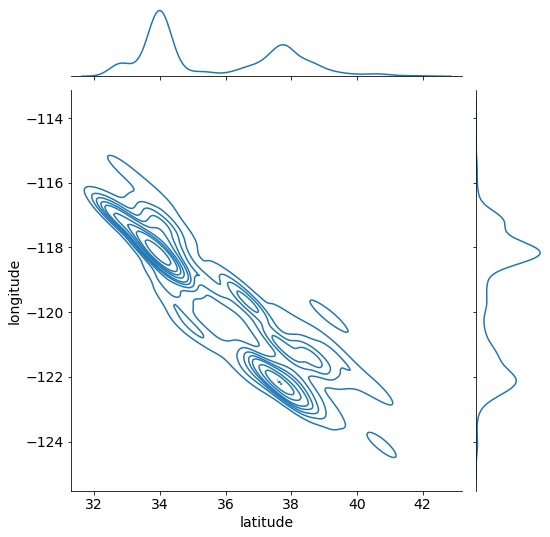

In [70]:
grid = sns.jointplot(df['latitude'], df['longitude'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [71]:
df['city'] = (df['longitude'] > -120) * 1

**Поиск выбросов с помощью box plot**

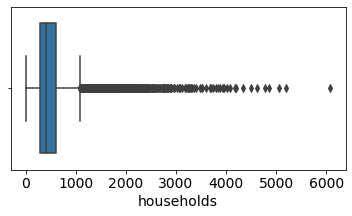

In [72]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['households'], whis=1.5)

plt.xlabel('households')
plt.show()

In [73]:
df.loc[df['households'] > 800, 'households'] = df['households'].median()

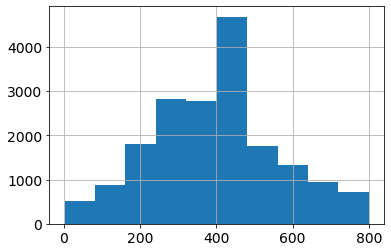

In [74]:
df['households'].hist();

### Категориальные признаки

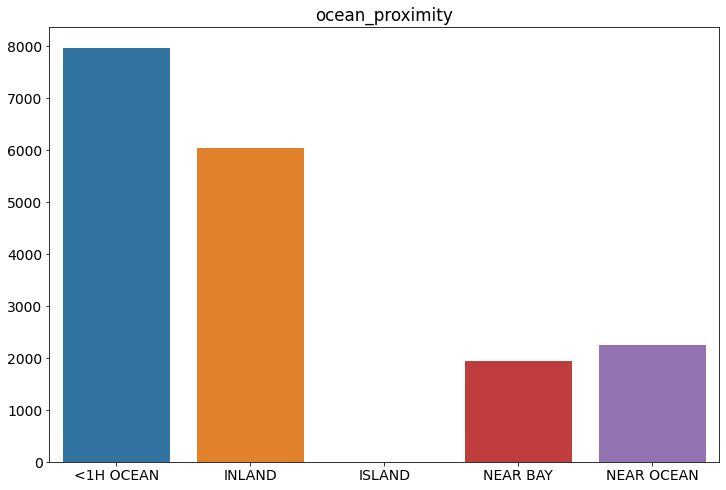

In [75]:
counts = df['ocean_proximity'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('ocean_proximity')
sns.barplot(counts.index, counts.values)
    
plt.show()

### Бинарные признаки

In [76]:
df_bin_features = df.select_dtypes(include='int8')

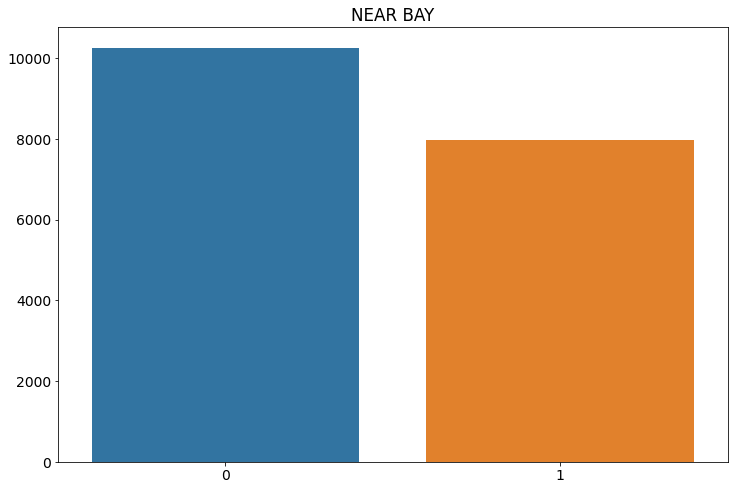

In [77]:
counts = df['NEAR BAY'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('NEAR BAY')
sns.barplot(counts.index, counts.values)
    
plt.show()

### Матрица корреляций

- Показывает линейную связь между переменными
- Изменяется от -1 до 1
- Корреляция - мера только __линейной__ связи

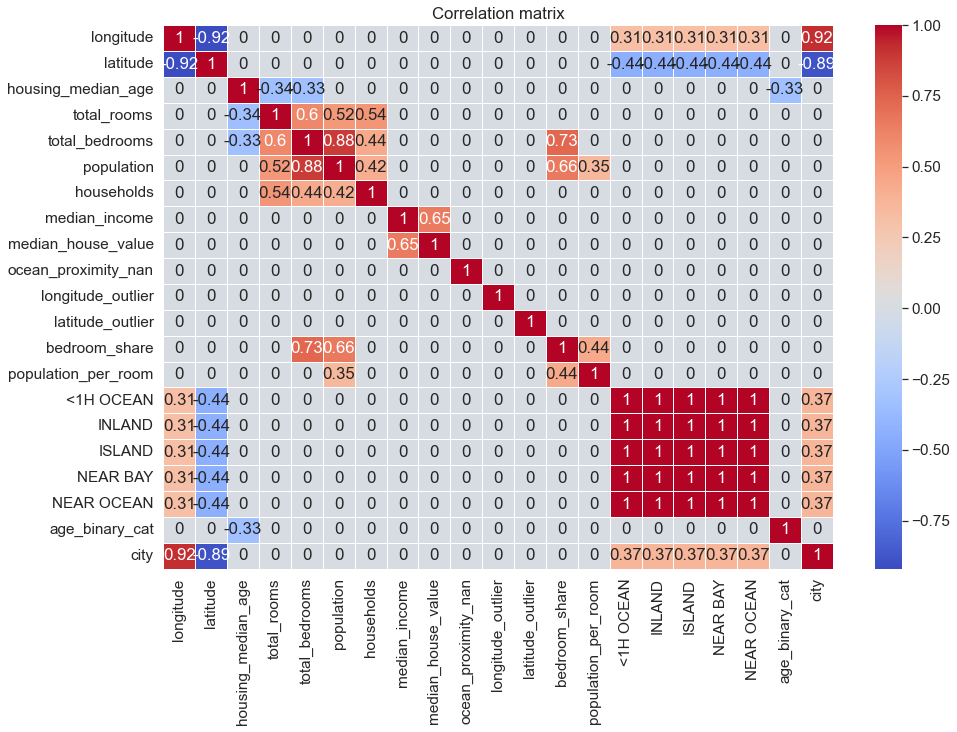

In [78]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# Анализ зависимости таргета от фичей

## Количественные признаки

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18234 entries, 0 to 20639
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   longitude            18234 non-null  float32 
 1   latitude             18234 non-null  float32 
 2   housing_median_age   18234 non-null  float32 
 3   total_rooms          18234 non-null  float32 
 4   total_bedrooms       18234 non-null  float32 
 5   population           18234 non-null  float32 
 6   households           18234 non-null  float32 
 7   median_income        18234 non-null  float32 
 8   median_house_value   18234 non-null  float32 
 9   ocean_proximity      18234 non-null  category
 10  ocean_proximity_nan  18234 non-null  int8    
 11  longitude_outlier    18234 non-null  int8    
 12  latitude_outlier     18234 non-null  int8    
 13  bedroom_share        18234 non-null  float32 
 14  population_per_room  18234 non-null  float32 
 15  <1H OCEAN          

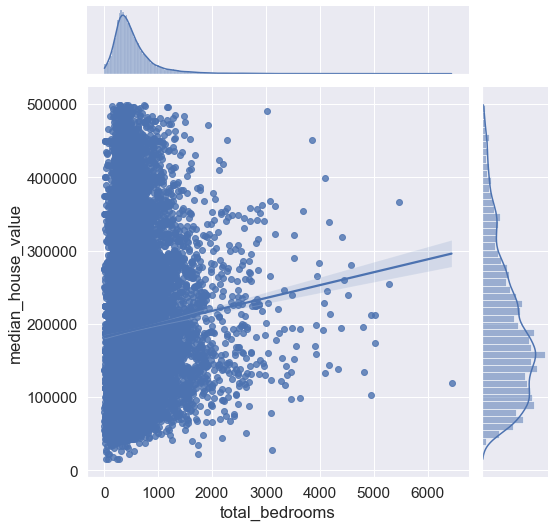

In [80]:
grid = sns.jointplot(df['total_bedrooms'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [81]:
df['many_bedrooms'] = (df['total_bedrooms'] > 3000) * 1

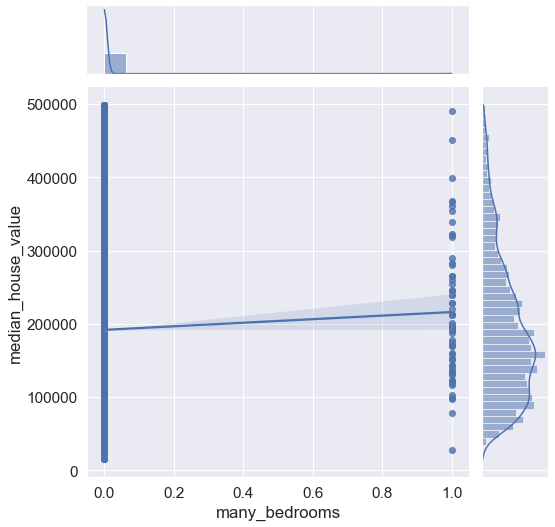

In [82]:
grid = sns.jointplot(df['many_bedrooms'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

**latitude**

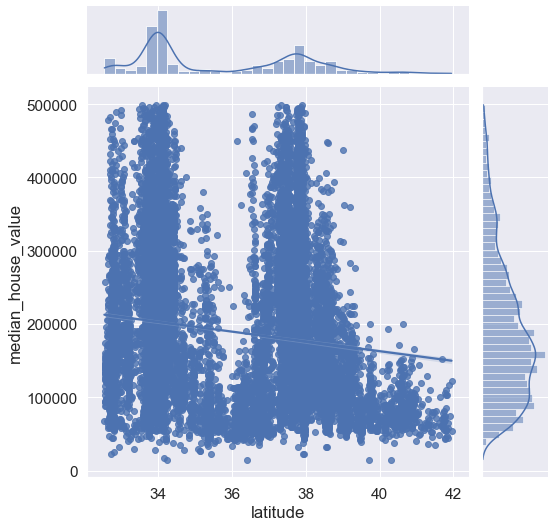

In [83]:
grid = sns.jointplot(df['latitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Видно два города, имеет смысл посмотреть на зависимость по отдельности

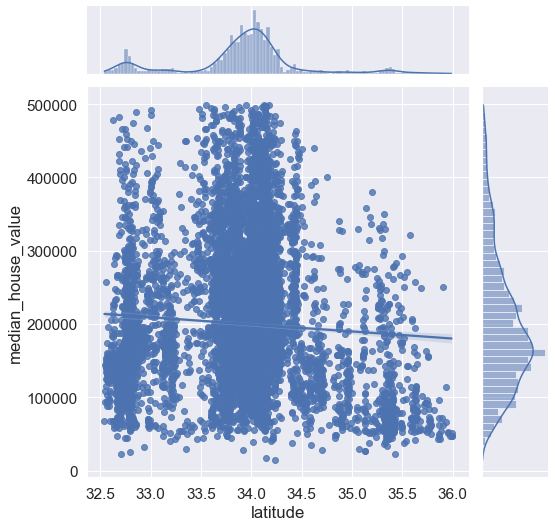

In [84]:
df_cut = df[df['latitude'] < 36]
grid = sns.jointplot(df_cut['latitude'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

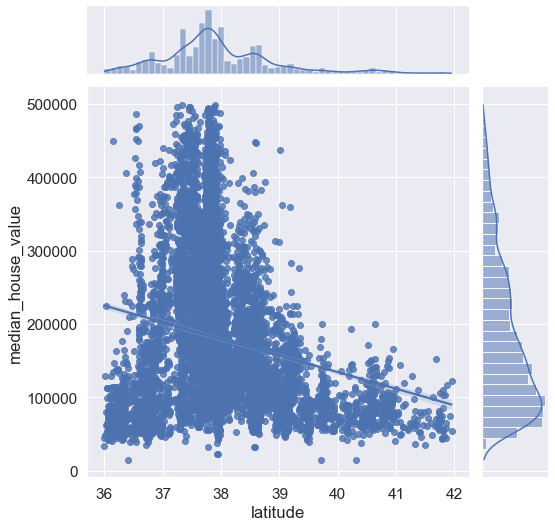

In [85]:
df_cut = df[df['latitude'] >= 36]
grid = sns.jointplot(df_cut['latitude'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

**longitude**

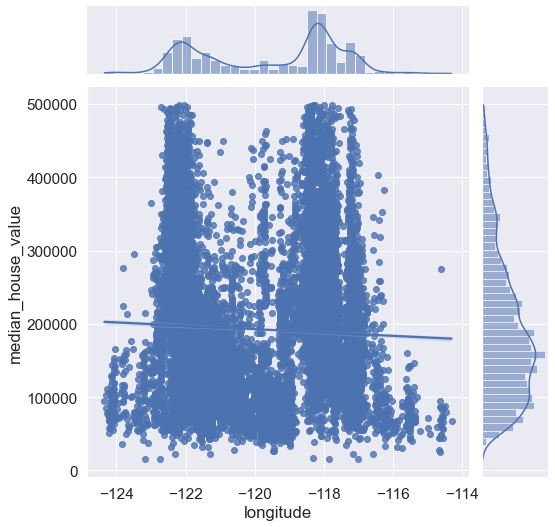

In [86]:
grid = sns.jointplot(df['longitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

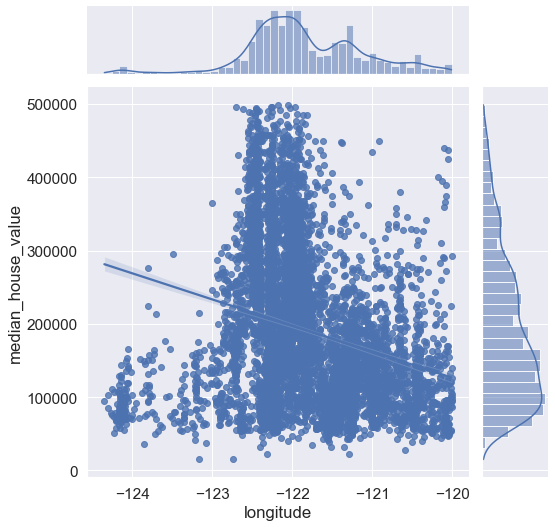

In [87]:
df_cut = df[df['longitude'] < -120]
grid = sns.jointplot(df_cut['longitude'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

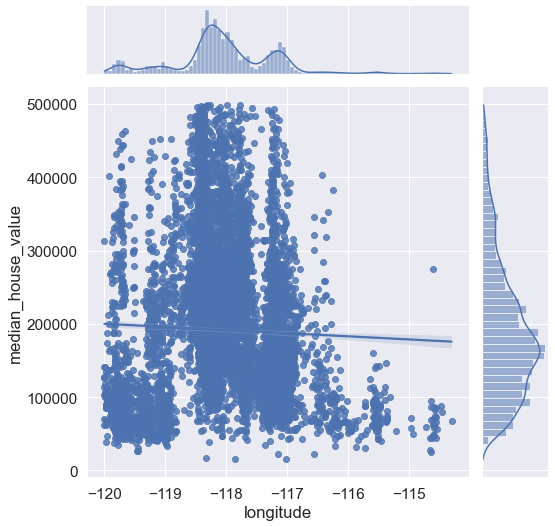

In [88]:
df_cut = df[df['longitude'] >= -120]
grid = sns.jointplot(df_cut['longitude'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

## Категориальные / бинарные признаки

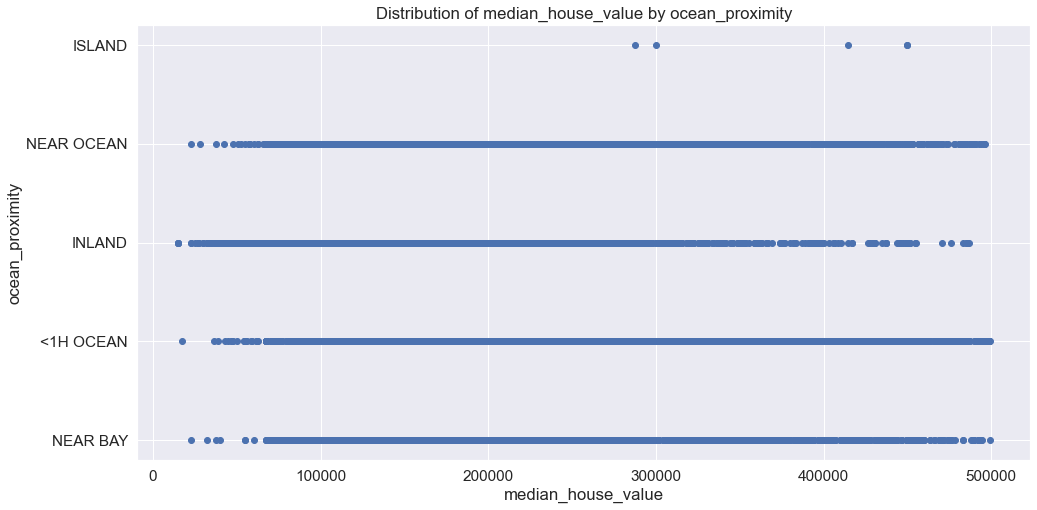

In [89]:
plt.figure(figsize=(16, 8))

plt.scatter(df['median_house_value'], df['ocean_proximity'])

plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

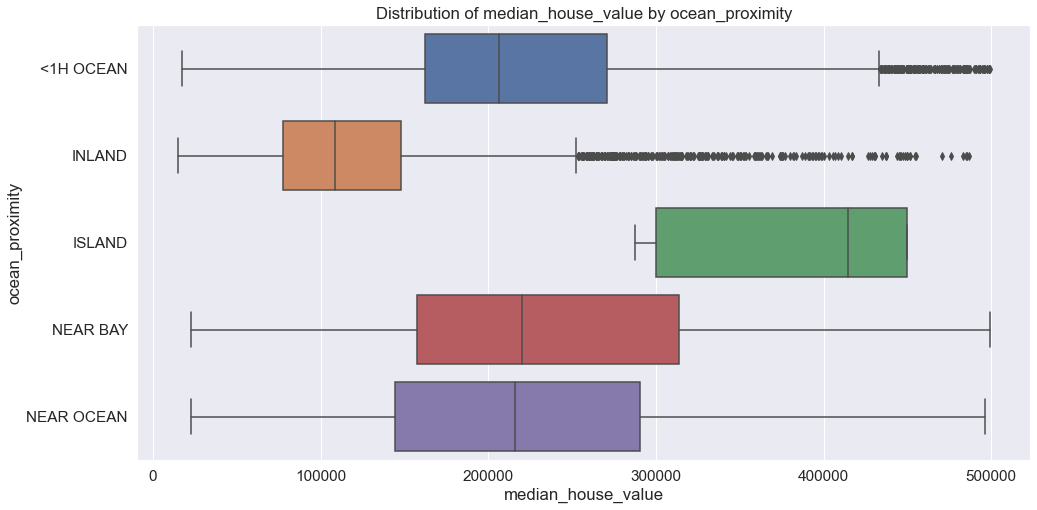

In [90]:
plt.figure(figsize=(16, 8))

sns.boxplot(df['median_house_value'], df['ocean_proximity'], whis=1.5)

plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

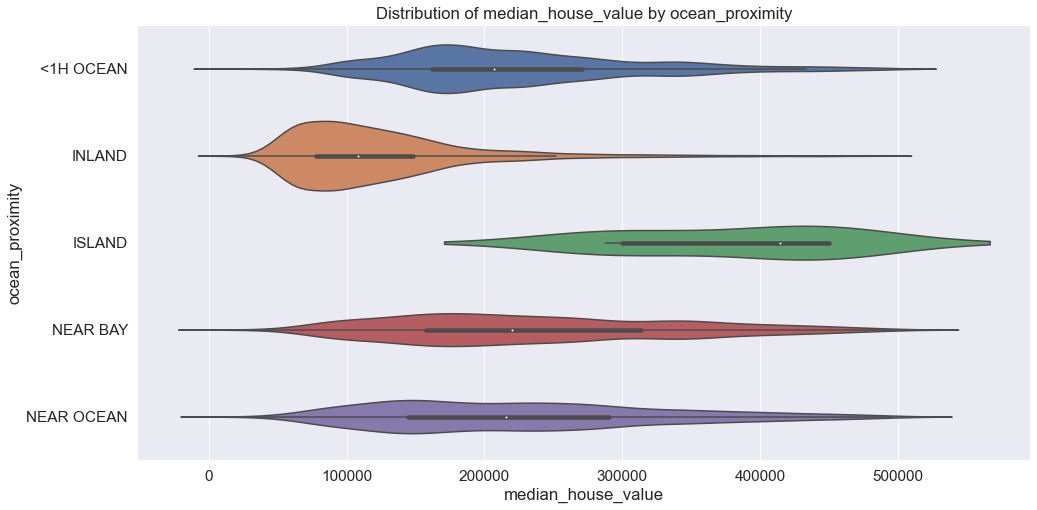

In [91]:
plt.figure(figsize=(16, 8))

sns.violinplot(df['median_house_value'], df['ocean_proximity'])

plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

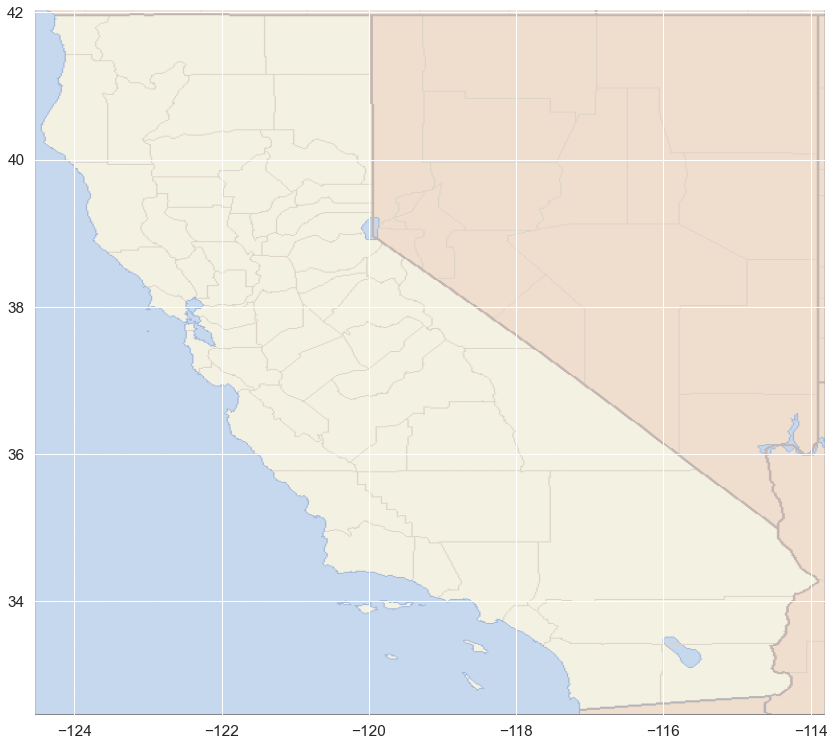

In [92]:
california_map = img.imread(CALIFORNIA_MAP_PATH)

plt.figure(figsize=(20,13))
plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.show()

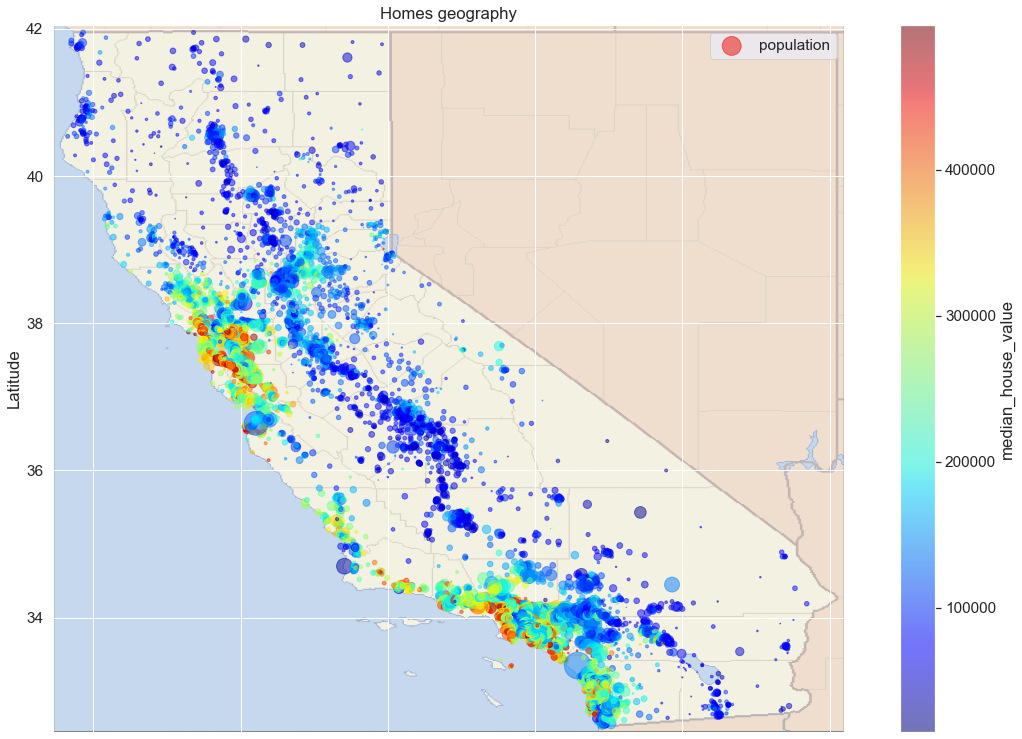

In [93]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
        s=df['population'] / 50, label='population', c='median_house_value', 
        cmap=plt.get_cmap('jet'), figsize=(20,13))

plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Homes geography")
plt.legend() 
plt.show()

# Обучение с учителем

**Оставим признаки, которые необходимы для модели**

In [94]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [95]:
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,410.0,8.3014,0,0,0,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,0,342200.0


**Стандартизация признаков** 

Вот здесь были боль и страдания почти 2 часа! После вызова Scaler-a и следующего оператора:
\
**df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)** 
\
появлялось куча NaN значений почти во всех признаках и дальше все ломалось. В итоге опытным путем я выяснил, что надо было сбросить индекс, т.к Scaler строит новый DataFrame с нормальным индексом, а в моем основном DataFrame после всех операций удаления строк с пустыми данными в признаках индекс получился с дырами. Нюанс однако)

In [96]:
df.reset_index(inplace=True)

In [97]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [98]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [99]:
stand_features

array([[-1.330505  ,  1.0354127 ,  1.0123057 , ..., -0.9771962 ,
        -1.6238513 ,  2.9610016 ],
       [-1.3255165 ,  1.0261123 , -0.58724904, ...,  0.8400499 ,
         0.09794101,  2.9458416 ],
       [-1.3354897 ,  1.0214614 ,  1.8920606 , ..., -0.8251035 ,
        -1.3146563 ,  2.2808394 ],
       ...,
       [-0.82178164,  1.784071  , -0.82718223, ..., -0.947477  ,
        -1.6966031 , -0.713326  ],
       [-0.876644  ,  1.75617   , -0.82718223, ..., -0.61094993,
        -0.2718806 , -1.152584  ],
       [-0.8367434 ,  1.7282691 , -0.9871377 , ..., -0.04628372,
         0.8254588 , -0.820465  ]], dtype=float32)

In [100]:
stand_features.shape

(18234, 8)

In [101]:
pd.DataFrame(stand_features, columns=feature_names_for_stand)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.330505,1.035413,1.012306,-1.137517,-0.973897,-0.977196,-1.623851,2.961002
1,-1.325516,1.026112,-0.587249,3.454696,1.345559,0.840050,0.097941,2.945842
2,-1.335490,1.021461,1.892061,-0.704066,-0.829080,-0.825104,-1.314656,2.280839
3,-1.340478,1.021461,1.892061,-0.846581,-0.722247,-0.770910,-1.060025,1.252570
4,-1.340478,1.021461,1.892061,-0.585920,-0.615414,-0.764791,-0.817519,0.107990
...,...,...,...,...,...,...,...,...
18229,-0.996342,1.681769,-0.027405,-0.065336,-0.342397,-0.348721,-0.302194,0.022826
18230,-0.761931,1.779420,-0.267338,-0.557860,-0.392253,-0.520044,-0.387071,-1.348072
18231,-0.821782,1.784071,-0.827182,-1.272647,-0.924042,-0.947477,-1.696603,-0.713326
18232,-0.876644,1.756170,-0.827182,-0.413869,-0.309161,-0.610950,-0.271881,-1.152584


In [102]:
df[feature_names_for_stand]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,410.0,8.3014
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462
...,...,...,...,...,...,...,...,...
18229,-121.559998,39.270000,28.0,2332.0,395.0,1041.0,344.0,3.7125
18230,-121.089996,39.480000,25.0,1665.0,374.0,845.0,330.0,1.5603
18231,-121.209999,39.490002,18.0,697.0,150.0,356.0,114.0,2.5568
18232,-121.320000,39.430000,18.0,1860.0,409.0,741.0,349.0,1.8672


In [103]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [104]:
df.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,0,-1.330505,1.035413,1.012306,-1.137517,-0.973897,-0.977196,-1.623851,2.961002,0,0,0,0,452600.0
1,1,-1.325516,1.026112,-0.587249,3.454696,1.345559,0.840050,0.097941,2.945842,0,0,0,0,358500.0
2,2,-1.335490,1.021461,1.892061,-0.704066,-0.829080,-0.825104,-1.314656,2.280839,0,0,0,0,352100.0
3,3,-1.340478,1.021461,1.892061,-0.846581,-0.722247,-0.770910,-1.060025,1.252570,0,0,0,0,341300.0
4,4,-1.340478,1.021461,1.892061,-0.585920,-0.615414,-0.764791,-0.817519,0.107990,0,0,0,0,342200.0


## Разбиение на train / test

In [105]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=12)

In [106]:
y_train.describe()

count     12763.000000
mean     191202.718750
std       96905.117188
min       14999.000000
25%      115200.000000
50%      172700.000000
75%      247900.000000
max      499100.000000
Name: median_house_value, dtype: float64

## Построение моделей

In [107]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Линейная регрессия

R2:	0.616
RMSE:	60057.685
MSE:	3606925532.768


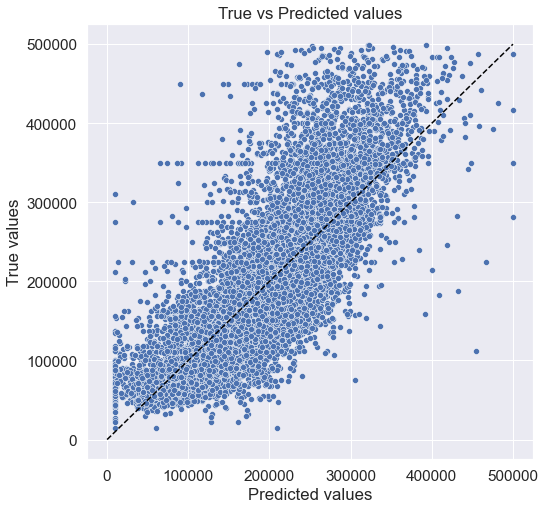

In [108]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.601
RMSE:	61464.107
MSE:	3777836432.094


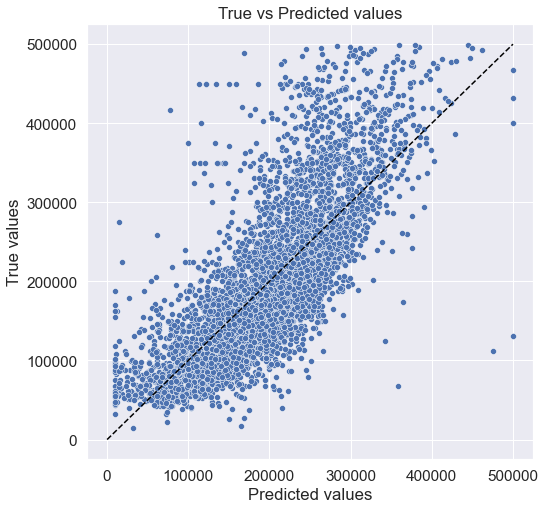

In [109]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

### Деревья решений

R2:	1.0
RMSE:	0.0
MSE:	0.0


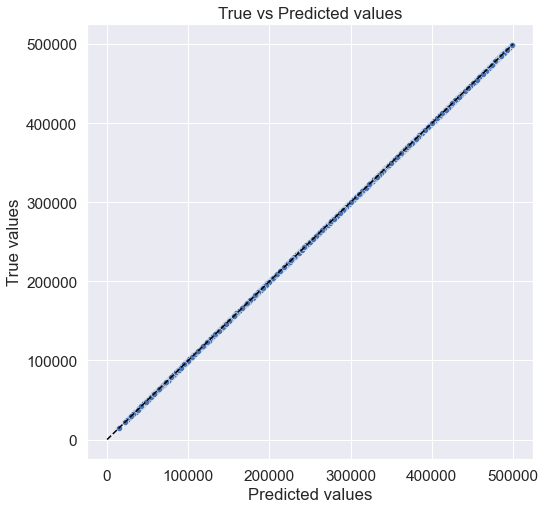

In [110]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.58
RMSE:	63106.391
MSE:	3982416643.575


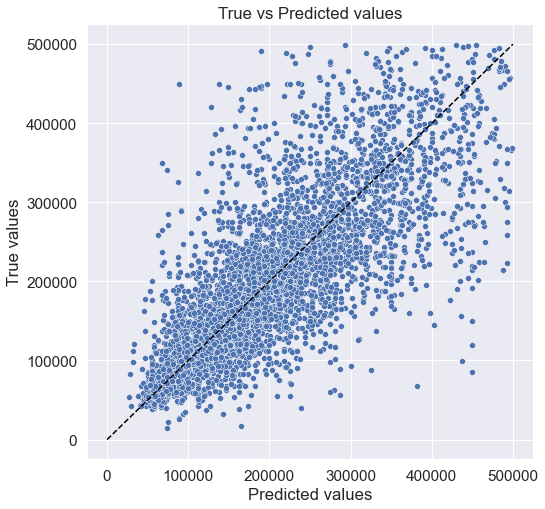

In [111]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Случайный лес

R2:	0.77
RMSE:	46517.285
MSE:	2163857845.354


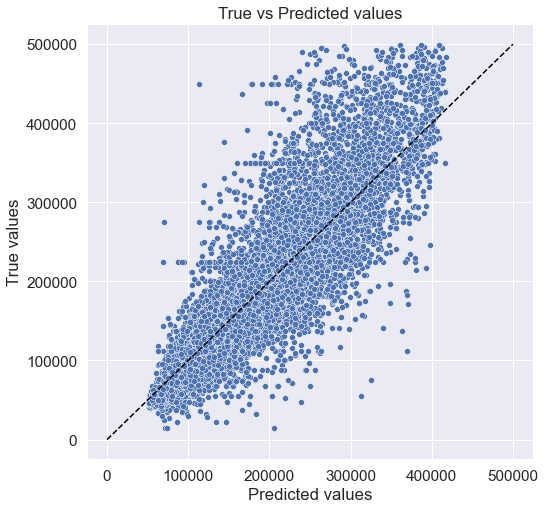

In [112]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.723
RMSE:	51231.327
MSE:	2624648856.875


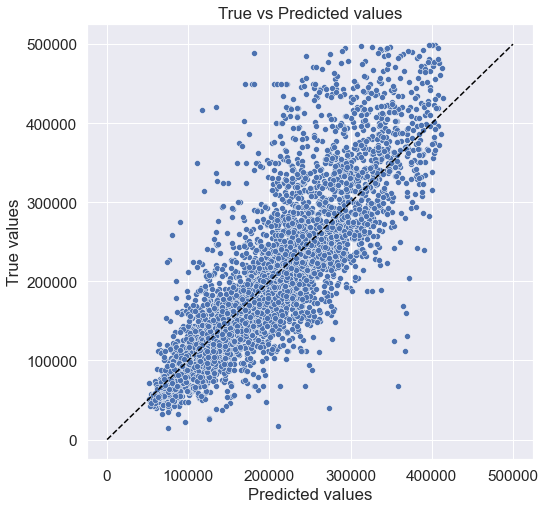

In [113]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Градиентный бустинг. Решающие деревья.

R2:	0.897
RMSE:	31122.38
MSE:	968602514.246


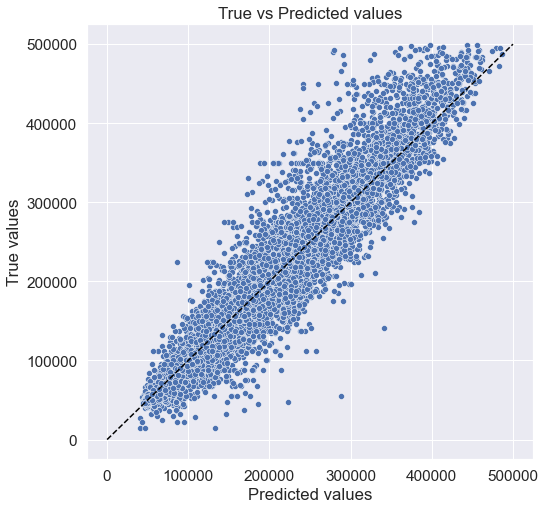

In [114]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.802
RMSE:	43355.011
MSE:	1879656970.426


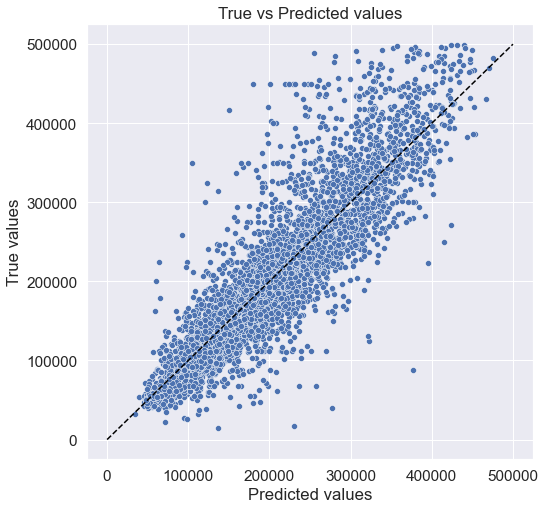

In [115]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Выводы

По результатам анализа можно сказать, что лучшей моделью для данной задачи будет Градиентный бустинг.\
И как оказалось, удаление некорректных данных вероятно дало нам лучший результат оценки по сравнению с тем, который мы получали при замене отсутствующих данныз (NaN) на медианы.